# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

## Setup

### Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User parameters

In [2]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/David Carruthers sample injection order.xlsx'
}

In [3]:
ls

check_original_prot_map.ipynb      get_Pputida_unreviewed_uniprot.ipynb
choose_targets_sandbox.ipynb       normalize_and_recommend.ipynb
data/                              normalize_and_recommend_v2.ipynb
DBTL1Recs4David.ipynb              results/
DBTL1Recs4David_local.ipynb        test_normalize_checkpivot.ipynb
DBTL1Recs4David_plotupdates.ipynb  test_normalize.ipynb
get_Pputida_uniprot.ipynb


### Useful functions

In [4]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

In [5]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [6]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

## Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [7]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [8]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [9]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

100%|██████████| 1182270/1182270 [01:02<00:00, 18981.59it/s]


There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [10]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## Preprocess and inspect data

### Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [11]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182265    False
1182266    False
1182267    False
1182268    False
1182269    False
Name: Protocol, Length: 1182270, dtype: bool

In [12]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [13]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [14]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [15]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [16]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [17]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [18]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [19]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [20]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02
...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05


In [21]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588


In [22]:
print(df2.shape)

(1033140, 6)


## Modify fields in dataframe to enable processing
Steps to convert EDD data to useable format:
1. Add strain names to dataframe
2. Get UniProt names from Formal Type column
3. Limit protein data to only target genes
4. Convert Uniprot names to gene target (PP_####) names
5. Add target gene to each row

### 1. Add strain name to dataframe using prebuilt function.


In [23]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

(1033140, 7)


### 2. Bring out Uniprot names

In [24]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)

get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'

print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [25]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590


In [26]:
print(df2.shape)

(1033140, 7)


### 3. Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [27]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [156]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

139

#### Protein-gene mapping sanity check
Need to check: is there a 1 to 1 correspondence between target genes and uniprot IDs?

There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [29]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets have show up multiple times in the list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets have show up multiple times in the list:
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: CRISPRi target gene, dtype: int64
These Uniprot IDs show up multiple times
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: UNIPROT ID, dtype: int64


#### Drop the rows that are not in targets from Proteomics protocol:

In [30]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)


(41712, 7)


In [52]:
len(targets_in_mapping)

122

### 4. Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [31]:
protein_map = {}
for index in ProtMapping_df.index:
    protein_map[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [32]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: protein_map[x])

### 5. Add Target Gene
Add column with a target gene for each strain.

In [33]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
 Input string: PP_4549-R1, output: PP_4549


In [34]:
df2['Target'] = df2['Line Name'].apply(get_target_gene)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774


In [59]:
df2_formal_types = df2['Formal Type'].unique()
df2_targets = df2['Target'].unique()

print('Targets not measured')
_ = [print(ii) for ii in df2_targets if ii not in df2_formal_types]

print('Measurements not in target')
_ = [print(ii) for ii in df2_formal_types if ii not in df2_targets]

df2['target_measured'] = np.nan
check_if_measured = lambda x: 1 if x in df2_formal_types else 0
df2['target_measured'] = df2['Target'].apply(check_if_measured)
df2.head()


Targets not measured
PP_0362
PP_2589
PP_3744
PP_3394
PP_3355
PP_3282
PP_1157
PP_1394
PP_4737
PP_3280
PP_0806
PP_4043
PP_0104
PP_0105
PP_0106
PP_0814
PP_0815
PP_4161
PP_4160
PP_4159
PP_0277
PP_4128
PP_5420
Control
Measurements not in target
cid:12988
PP_4190
PP_4129


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,target_measured
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549,False,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550,False,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368,False,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136,False,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774,False,1


High producers with missing target measurements:
              Value  target_measured
Target                              
PP_0814  468.593867              0.0
PP_0815  388.466700              0.0
PP_3355  362.581600              0.0
PP_3744  338.701100              0.0
PP_0362  323.684267              0.0


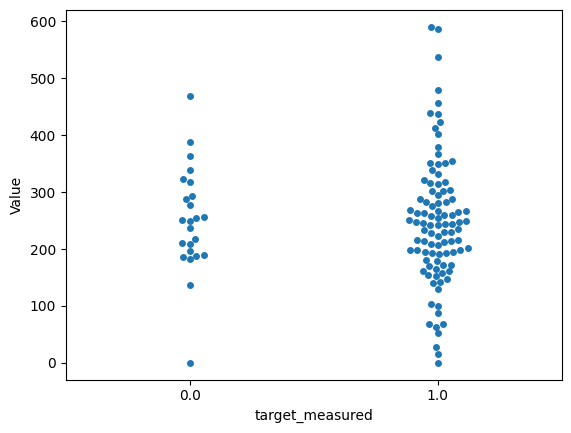

In [99]:
iso_by_target_measured = df2[df2['Formal Type'] == 'cid:12988'].loc[:, ('Line Name', 'Target', 'Value', 'target_measured')]
iso_by_target_measured['mean_iso'] = np.nan
add_mean_iso = lambda x: np.mean(iso_by_target_measured.loc[iso_by_target_measured['Target']==x, 'Value'])
iso_by_target_measured['mean_iso'] = iso_by_target_measured['Target'].apply(add_mean_iso)

iso_grouped = iso_by_target_measured.loc[:,['Target', 'Value', 'target_measured']].groupby('Target').mean()
iso_grouped
sns.swarmplot(iso_grouped, y = 'Value', x = 'target_measured')
print('High producers with missing target measurements:')
print(iso_grouped[iso_grouped['target_measured']==0].sort_values('Value', ascending=False).iloc[0:5, :])
with open(f"{user_params['output_dir']}/targets_missing_proteomics_measurement.txt", "w") as outfile:
    outfile.write(str(iso_grouped[iso_grouped['target_measured']==0].sort_values('Value', ascending=False)))


## Normalize based on sample run time

1. Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
2. Pull out controls from each day
3. Get rid of proteins missing from controls
4. Normalize each run by control mean
5. Compare the distributions of normalized and unnormalized proteins

### 1. Check correspondence between lists of line names.

Import order of runs.

In [100]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()


,Sample Name in order injected,Batch number
0,Control-R1,1
1,Control-R2,1
2,Control-R3,1
3,Control-R4,1
4,Control-R5,1


Make a sample->day dictionary


In [101]:
batch_day_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

In [102]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
print(f'Sorted, unique names are identical: {"Yes" if unique_sample_names_df2 == unique_sample_names_order else "No"}')
assert unique_sample_names_df2 == unique_sample_names_order, "ERROR: sample names don't match in spreadsheets."

Sorted, unique names are identical: Yes


### 2. Pull out controls and look at distributions of proteomics

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [103]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)
df_control = df2[df2['Control']].copy()
print(df_control.shape)

(1779, 10)


Find day each experiment was conducted and add to dataframe.

In [104]:
find_expt_day = lambda x: batch_day_dict[x]
df_control['Batch number'] = df_control['Line Name'].apply(find_expt_day)

Print the day for each control - they aren't uniformly distributed.

In [105]:
for ii in range(1,4):
    print(f'Controls on day {ii}: {df_control[df_control["Batch number"] == ii]["Line Name"].unique()}')

Controls on day 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls on day 2: ['Control-R8' 'Control-R9' 'Control-R10' 'Control-R11' 'Control-R12'
 'Control-R13' 'Control-R14']
Controls on day 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


### 3. Check for proteins missing from each day and drop them

Check how many different analytes are measured in controls.

In [106]:
print(f'There are {len(df_control["Measurement Type"].unique())} unique analytes in the control dataframe')

There are 96 unique analytes in the control dataframe


Create pivot table based on batch number. 

In [107]:
cntrl_pivot_by_type_exist = pd.pivot_table(df_control, values = 'Value', columns = 'Batch number', index = 'Formal Type', aggfunc = np.mean)
cntrl_pivot_by_type_exist

Batch number,1,2,3
Formal Type,,,
PP_0001,5.382129e+06,3.827842e+06,2.740936e+06
PP_0103,NaN,NaN,1.723723e+04
PP_0168,9.470668e+06,1.091311e+07,5.121947e+06
PP_0225,NaN,6.933567e+03,4.309307e+03
PP_0226,2.374870e+05,2.952860e+05,1.104318e+05
...,...,...,...
PP_5335,5.345711e+06,5.510655e+06,3.765555e+06
PP_5416,7.956082e+06,9.817154e+06,6.652987e+06
PP_5417,3.074205e+07,2.764930e+07,1.941464e+07


Check for NaN measurements in control runs. 

In [108]:
print(f'There are: {sum(cntrl_pivot_by_type_exist.isna())} NaNs in measurement pivot table')

There are: 6 NaNs in measurement pivot table


In [109]:
any_measurement_missing = np.where(np.any(cntrl_pivot_by_type_exist.isna(), 1))
cntrl_pivot_by_type_exist.iloc[any_measurement_missing][:]

Batch number,1,2,3
Formal Type,,,
PP_0103,NaN,NaN,17237.2300
PP_0225,NaN,6933.567143,4309.3075
PP_0548,NaN,NaN,4309.3075
PP_4650,16068.194286,13867.134286,NaN


Print isoprenol titers for Formal Types missing from controls

In [127]:
formal_types_missing = cntrl_pivot_by_type_exist.iloc[any_measurement_missing][:].index.values
iso_grouped.loc[formal_types_missing,:]
# iso_grouped[formal_types_missing[0]]
# iso_grouped[iso_grouped['Target'].isin(formal_types_missing)]
with open(f"{user_params['output_dir']}/targets_missing_controls_measurement.txt", "w") as outfile:
    outfile.write(str(iso_grouped.loc[formal_types_missing,:]))


Add batch number to dataframe and make a copy.

In [128]:
df2['Batch number'] = df2['Line Name'].apply(find_expt_day)
df_norm = df2.copy()

Get measurement types that have all their control values. 

In [139]:
cntrl_pivot_by_type_exist = cntrl_pivot_by_type_exist.dropna() 
list_of_control_type = cntrl_pivot_by_type_exist.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_type else 0
df_norm['can_normalize'] = df_norm['Formal Type'].apply(check_norm_exist)
df_norm

array(['PP_4650', 'PP_0225', 'PP_0548', 'PP_0103'], dtype=object)

Drop measurements that can't be normalized. 

In [140]:
df_norm = df_norm[df_norm['can_normalize'] == 1]
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,target_measured,Batch number,can_normalize
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549,False,1,1,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550,False,1,1,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368,False,1,1,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136,False,1,1,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774,False,1,1,1


### 4. Normalize each run to the mean of that day's controls

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [141]:
df_norm['control_val'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    add_correct_normalization_value = lambda x: cntrl_pivot_by_type_exist[ii][x]
    df_norm.loc[df_norm['Batch number']== ii, 'control_val'] = df_norm[df_norm['Batch number']== ii]['Formal Type'].apply(add_correct_normalization_value)

/tmp/ipykernel_1409066/4292167869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['control_val'] = np.nan


Add column to dataframe and fill it with normalized values. Don't normalize isoprenol.

In [142]:
df_norm['norm_value'] = np.nan
df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'Value']/df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'control_val']
df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'Value']
df_norm.head()

/tmp/ipykernel_1409066/2386590674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['norm_value'] = np.nan


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,target_measured,Batch number,can_normalize,control_val,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549,False,1,1,1,246.680643,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550,False,1,1,1,246.680643,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368,False,1,1,1,246.680643,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136,False,1,1,1,246.680643,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774,False,1,1,1,246.680643,215.1588


### 5. Visualize results

#### Plot raw and mean data for Control measurements:

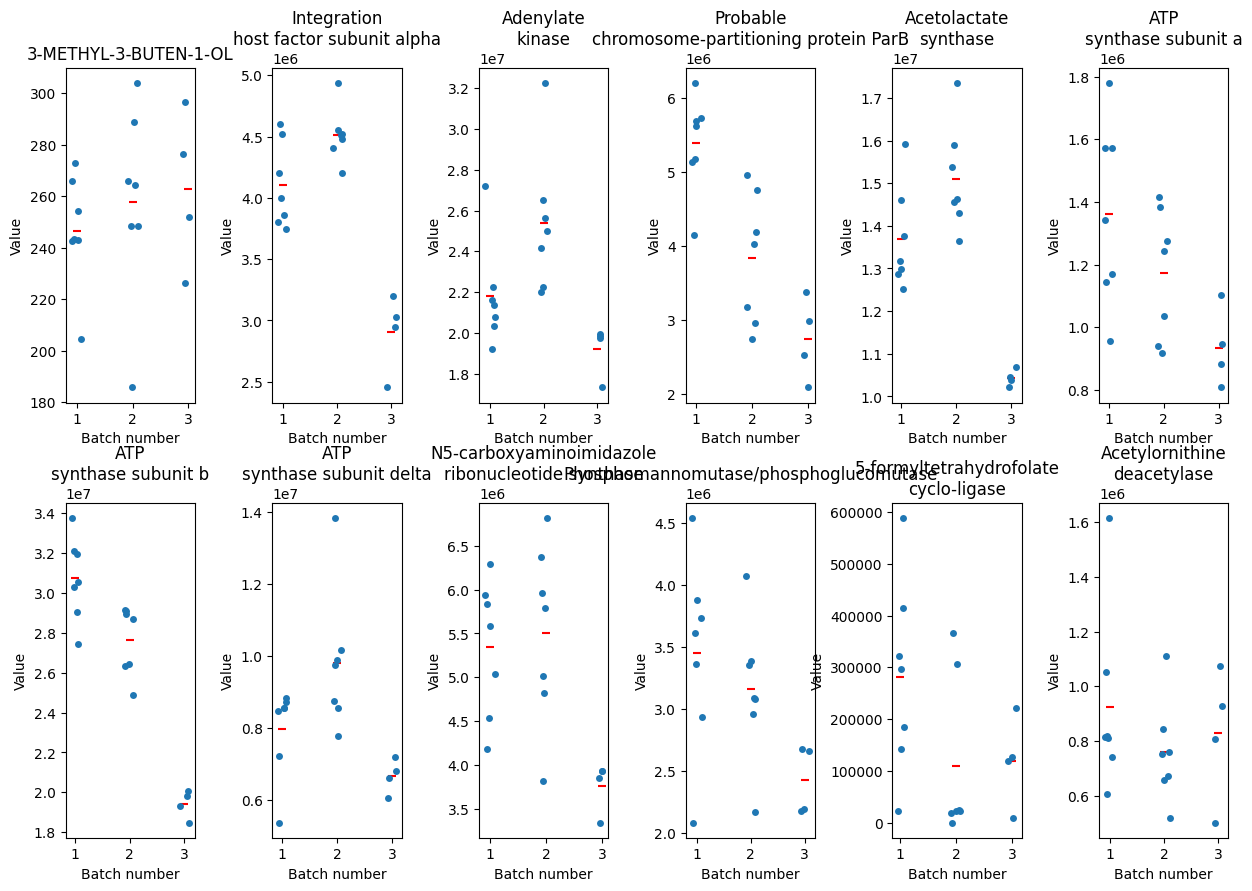

In [143]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch number'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch number', y = to_plot)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch number'] == batch_num)][to_plot]) for batch_num in batches]
                         
    _ = [ax.scatter(i, mean_vals[i], color = 'red', marker = '_') for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))

target_list_all = df_control['Measurement Type'].unique().tolist()
compare_swarm_multi(df_control, target_list_all[:12], [1,2,3])

#### Plot differences b/w measurements on each day
Calculating $\Delta$(counts) for (day 3) - (day 1) should skew negative for unnormalized data, but should go away with normalization.

Create function to plot the distribution of differences between days. 

In [144]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between days.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

Make pivot tables for normalized an unnormalized data and set up labels. 

In [145]:
cntrl_pivot_by_measurement_nonnorm = pd.pivot_table(df_norm, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
cntrl_pivot_by_measurement_norm = pd.pivot_table(df_norm, values = 'norm_value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['day 3 - day 1',
              'day 2 - day 1']

Make plots to show the distribution of differences. 

[(-10000000.0, 10000000.0), (-10000000.0, 10000000.0)]

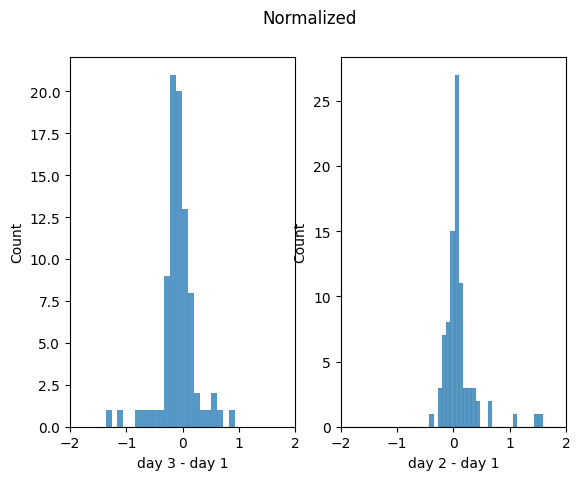

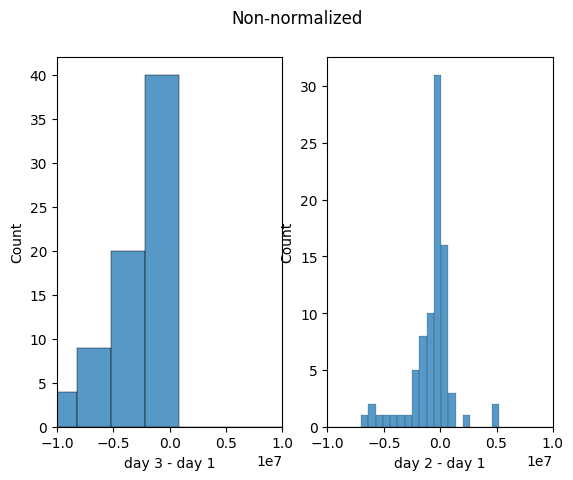

In [146]:
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_norm, dif_to_plot, dif_labels)
ax_lim = 2
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Normalized')

ax_lim = 1e7
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_nonnorm, dif_to_plot, dif_labels)
fig.suptitle('Non-normalized')
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]

#### Swarmplots for normalized values
These swarmplots compare the distribution of all proteins on each day before and after normalization. We can see that the normalization makes the difference in distributions much less. 



In [ ]:
target_list_filter = df_norm['Measurement Type'].unique().tolist()

compare_swarm_multi(df_norm, target_list_filter[:12], [1,2,3], to_plot='Value')

compare_swarm_multi(df_norm, target_list_filter[:12], [1, 2, 3], to_plot='norm_value')


## Statistical Analysis
### Pivot dataframe to table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value. Create one for normalized values and one for non-normalized values.

In [147]:
df_targets_norm = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "norm_value", aggfunc = np.mean)

df_targets = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "Value", aggfunc = np.mean)

Check values for control after normalization - should all be 1

In [148]:
normed_controls = df_targets_norm.loc['NT',:]
normed_controls[normed_controls.values != 1.00].index
non_unity_strains = normed_controls[abs(normed_controls.values-1.00)>0.000001].index[:-1].values
print(f'Strains where controls are not unity:{non_unity_strains}')

Strains where controls are not unity:[]


In [158]:
df_targets.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,9.210642e+06,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,95580.395556,1.620814e+06,106364.608889,...,6.638675e+06,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111
IY1586,4.941056e+06,1.236235e+07,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,76970.166667,2.718135e+06,126497.500000,...,3.389466e+06,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833
IY1587,3.383160e+06,6.041816e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,42837.280000,3.116909e+06,42837.280000,...,2.688070e+06,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567
IY1588,3.782190e+06,1.541983e+07,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,64499.540000,2.592476e+06,92070.706667,...,3.791270e+06,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800
IY1589,5.161205e+06,6.916297e+06,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,23194.100000,2.312057e+06,23194.100000,...,2.764658e+06,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900


In [170]:
print(df_targets_norm.shape)
df_targets_norm.head()

(128, 98)


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


Change compound ID to Isoprenol

In [151]:
df_targets_norm.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets_norm.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,2.075548,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,1.059699,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.840411,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.185321,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.864356,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900


Add the target genes to this table - create a map from the strains and targets in df_norm.

In [152]:
target_map = df_norm[['Strain', 'Target']].drop_duplicates().set_index("Strain")
target_map


,Target
Strain,
IY1586,PP_4549
IY1587,PP_4550
IY1588,PP_0368
IY1589,PP_2136
IY1590,PP_0774
...,...
IY2029,PP_4123
IY2032,PP_4128
IY2019,PP_5420


In [153]:
df_targets_norm.loc[target_map.index, 'Target'] = target_map['Target']
df_targets_norm.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


Some target genes are not present in the proteomics data:

In [154]:
print('Genes missing from proteomics data:')
for gene, titer in zip(df_targets_norm['Target'], df_targets_norm['Isoprenol mean']):
    if gene not in df_targets_norm.columns:
        print(f'gene: {gene}\ttiter: {titer}')

Genes missing from proteomics data:
gene: PP_0362	titer: 323.68426666666664
gene: PP_2589	titer: 287.56166666666667
gene: PP_3744	titer: 338.7011
gene: PP_3394	titer: 0.0
gene: PP_3355	titer: 362.5816
gene: PP_3282	titer: 236.63643333333334
gene: PP_1157	titer: 251.74173333333337
gene: PP_1394	titer: 256.00190000000003
gene: PP_3280	titer: 292.92156666666665
gene: PP_4737	titer: 277.27653333333336
gene: PP_0548	titer: 457.3372
gene: PP_5420	titer: 137.40613333333332
gene: PP_0806	titer: 318.11353333333335
gene: PP_4128	titer: 249.49306666666666
gene: PP_4043	titer: 210.4665
gene: PP_0103	titer: 275.28249999999997
gene: PP_0104	titer: 195.62213333333332
gene: PP_0105	titer: 217.25286666666668
gene: PP_0106	titer: 187.54706666666667
gene: PP_0814	titer: 468.59386666666666
gene: PP_0815	titer: 388.4667
gene: PP_4161	titer: 182.96123333333333
gene: PP_4160	titer: 186.67336666666665
gene: PP_4159	titer: 208.75657666666666
gene: PP_0277	titer: 189.99164333333331
gene: PP_4650	titer: 191.2284

### Proteomics data

Now we can add the statistical data from the proteomics data (mean, std, first and third quantile):

In [171]:
df_targets_norm = find_library_stats(df_targets_norm)
df_targets_norm.head()

/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None


Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


### Isoprenol production data

Find CV for isoprenol production.

In [172]:
df_isoprenol             = df_norm[df_norm['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control', 'Batch number', 'can_normalize'])
stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
stats_isoprenol.rename(columns={'Value': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

/tmp/ipykernel_1409066/1808311546.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
/tmp/ipykernel_1409066/1808311546.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']


,mean,target_measured,control_val,norm_value,std,CV[%]
Strain,,,,,,
IY2192,15.849800,1.0,262.882475,15.849800,27.452659,173.205081
IY1671,100.588117,1.0,260.397102,100.588117,110.470009,109.824115
IY2025,27.581113,1.0,262.882475,27.581113,23.906693,86.677767
IY2195,63.463733,1.0,262.882475,63.463733,39.644337,62.467704
IY1597,275.054650,1.0,254.781559,275.054650,93.993453,34.172646


Add these stats to the dataframe:

In [173]:
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol['CV[%]'] = None

strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol.drop(columns='Formal Type', inplace=True)
df_isoprenol.set_index("Strain", inplace=True)
df_targets_norm.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]

In [197]:
df_targets_norm

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5417,PP_5419,Isoprenol mean,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.937266,0.600624,289.814111,PP_1607,20.218016,0.835546,0.895268,0.950706,0.837033,-0.859869
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,1.046875,0.346177,302.681833,PP_4549,1.258797,0.051375,0.073656,0.08812,0.062872,-3.694537
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.995729,0.162470,154.452567,PP_4550,8.410108,0.585066,0.232314,0.750753,0.226879,-0.387519
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.002899,0.854964,355.020800,PP_0368,4.072284,0.032587,0.038234,0.04758,0.035231,-2.202514
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.987194,0.711793,351.199900,PP_2136,0.74632,0.036127,0.03451,0.040185,0.031508,-3.533457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,254.648694,Control,11.693238,None,None,None,None,None
Library_mean,0.971413,1.392877,0.990227,0.896029,0.852300,0.913986,1.098607,0.718635,0.816521,3.369946,...,1.020761,0.321725,NaN,NaN,NaN,None,None,None,None,None
Library_std,0.184909,0.823098,0.652679,0.140861,0.372172,0.341719,0.278543,0.900159,0.330427,4.914288,...,0.121520,0.333621,NaN,NaN,NaN,None,None,None,None,None


Repeat procedure for df_targets

In [199]:
df_targets = find_library_stats(df_targets)
df_targets.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets.loc[target_map.index, 'Target'] = target_map['Target']
df_targets.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]
df_targets

/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1409066/982832173.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None


Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5417,PP_5419,Isoprenol mean,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,9.210642e+06,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,95580.395556,1.620814e+06,106364.608889,...,2.881347e+07,8.183859e+05,289.814111,PP_1607,20.218016,0.962351,None,None,None,None
IY1586,4.941056e+06,1.236235e+07,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,76970.166667,2.718135e+06,126497.500000,...,3.218307e+07,4.716865e+05,302.681833,PP_4549,1.258797,None,None,None,None,None
IY1587,3.383160e+06,6.041816e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,42837.280000,3.116909e+06,42837.280000,...,3.061075e+07,2.213753e+05,154.452567,PP_4550,8.410108,None,None,None,None,None
IY1588,3.782190e+06,1.541983e+07,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,64499.540000,2.592476e+06,92070.706667,...,3.083117e+07,1.164940e+06,355.020800,PP_0368,4.072284,None,None,None,None,None
IY1589,5.161205e+06,6.916297e+06,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,23194.100000,2.312057e+06,23194.100000,...,3.034837e+07,9.698603e+05,351.199900,PP_2136,0.74632,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,4.190752e+06,9.065235e+06,231729.880000,6.404960e+07,7.475888e+06,414110.655556,7.558040e+05,155680.649444,2.558789e+06,29536.403889,...,2.702211e+07,1.193798e+06,254.648694,Control,11.693238,None,None,None,None,None
Library_mean,3.414433e+06,9.349293e+06,185201.354357,5.084225e+07,5.920965e+06,295036.870542,6.907668e+05,108406.520604,1.582211e+06,105111.291374,...,2.414633e+07,3.813389e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Library_std,1.002450e+06,4.764965e+06,143476.518113,1.375086e+07,3.444215e+06,132166.182716,2.791358e+05,113235.829251,9.301894e+05,146851.522395,...,5.414382e+06,4.036474e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Visualization
Visualize isoprenol production and CV. First, some useful functions.

In [175]:
def plot_filter_results(df_all, df_filter, horiz_thresh, vert_thresh, x_fields):
    n_plots = len(x_fields)
    fig,ax = plt.subplots(1,n_plots)
    
    for ii in range(n_plots):
        ax[ii].scatter(df_all[x_fields[ii]], df_all['Isoprenol mean'], color = 'blue', alpha = 0.5, label = 'all targets')
        ax[ii].scatter(df_filter[x_fields[ii]], df_filter['Isoprenol mean'], color = 'red', label = 'targets after filtering')
        ax[ii].set_xlim([0, 2])
        ax[ii].axvline(vert_thresh[ii], color = 'k')
        ax[ii].axhline(horiz_thresh[ii], color = 'k')
        ax[ii].set_xlabel(x_fields[ii])
        if ii == 0:
            ax[ii].set_ylabel('Isoprenol Mean')
            ax[ii].legend()
    return fig

In [176]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
        
    ## create figure
    fig, ax = plt.subplots(figsize=(20,5))
    sns.set_style('white')

    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod,
                        x = 'Strain',
                        y = product,
                        color = 'salmon',
                        )
    ## Format isoprenol axis
    g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
    control_xval = np.where(df_prod.index.unique() == 'NT')
    plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
                df_control_stat[product], 
                marker = 'o', 
                color = 'none', 
                edgecolor = 'k', 
                label = 'control')
    
    ax.set_ylabel(product + " [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    
    ## Create %CV axis
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                        x='Strain',
                        y='CV[%]', 
                        color='gray',
                        marker='o',
                        ax=ax2)
    plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],
                    marker='o', color="None",  edgecolor='k', label='Control'
                    )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()
    ## Save figure
    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [177]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value'):
    
    # Figure dimensions, color and label
    fig_height = 15
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3
                )

            # Add control
            plt.plot(df_targets.loc[control_strain, target], '.', color='k', markersize=10)

            # Add target
            data = df_targets[df_targets['Target']==target][target]
            if len(data)==1:
                plt.plot(data, marker='_', color=color, markersize=50, markeredgewidth=3)

            # Set y limits
            #ylim = np.max(df_targets[target]) + 50
            #ax.set_ylim([0, ylim])

        sns.despine(left=False, bottom=True)
        if save_name is None:
            save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
        if save:
            fig.savefig(
                save_name,
                transparent=True,
                bbox_inches="tight",
                dpi=300,
                )
    return fig

In [178]:
df_isoprenol.head()

,Isoprenol,Target,target_measured,control_val,norm_value,CV[%]
Strain,,,,,,
IY2020,618.3056,PP_5419,1,257.911729,618.3056,5.359461
IY1688,603.9709,PP_0528,1,257.911729,603.9709,2.279287
IY1688,590.6272,PP_0528,1,257.911729,590.6272,2.279287
IY2020,587.8620,PP_5419,1,257.911729,587.8620,5.359461
IY1688,577.0506,PP_0528,1,257.911729,577.0506,2.279287


In [179]:
control_strain = df_norm.loc[df_norm['Control']==True,:]['Strain'].unique()[0]
df_control_stat = df_isoprenol.loc[control_strain]

/tmp/ipykernel_1409066/513522599.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
/tmp/ipykernel_1409066/513522599.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
/tmp/ipykernel_1409066/513522599.py:35: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],


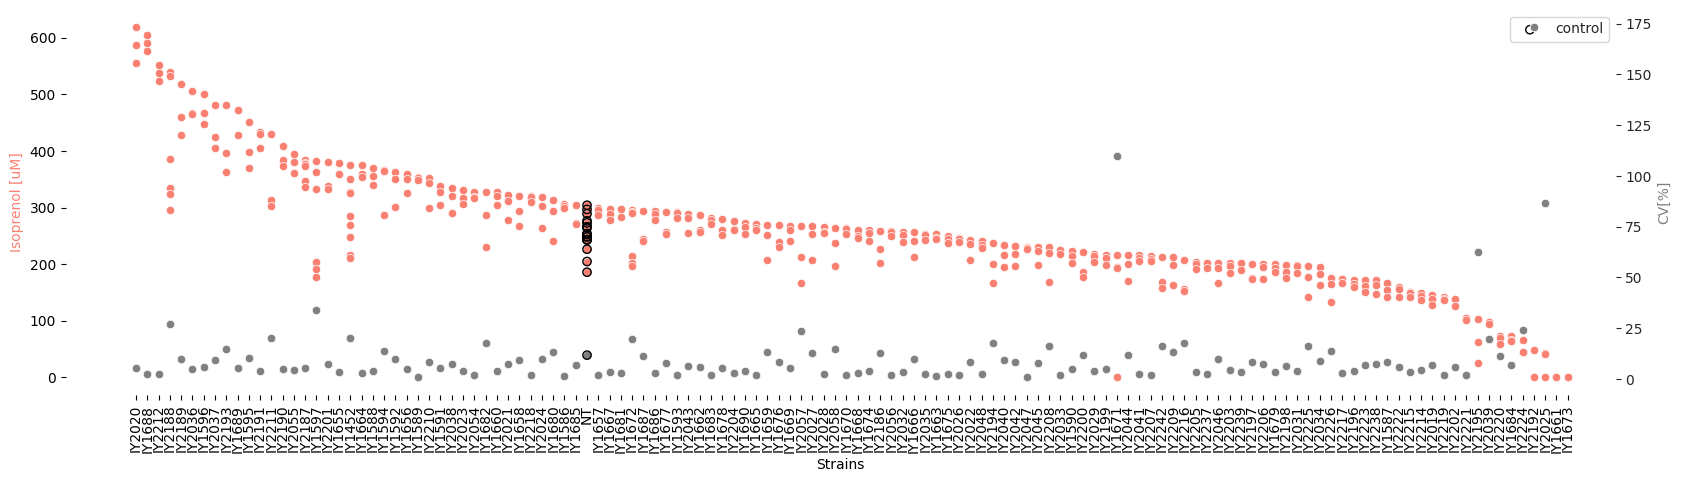

In [180]:
plot_titers(df_isoprenol, df_control_stat, 'Isoprenol')

Visualize distribution of proteomics levels in each strain (distributions) compared to the strain where that protein was targeted. 

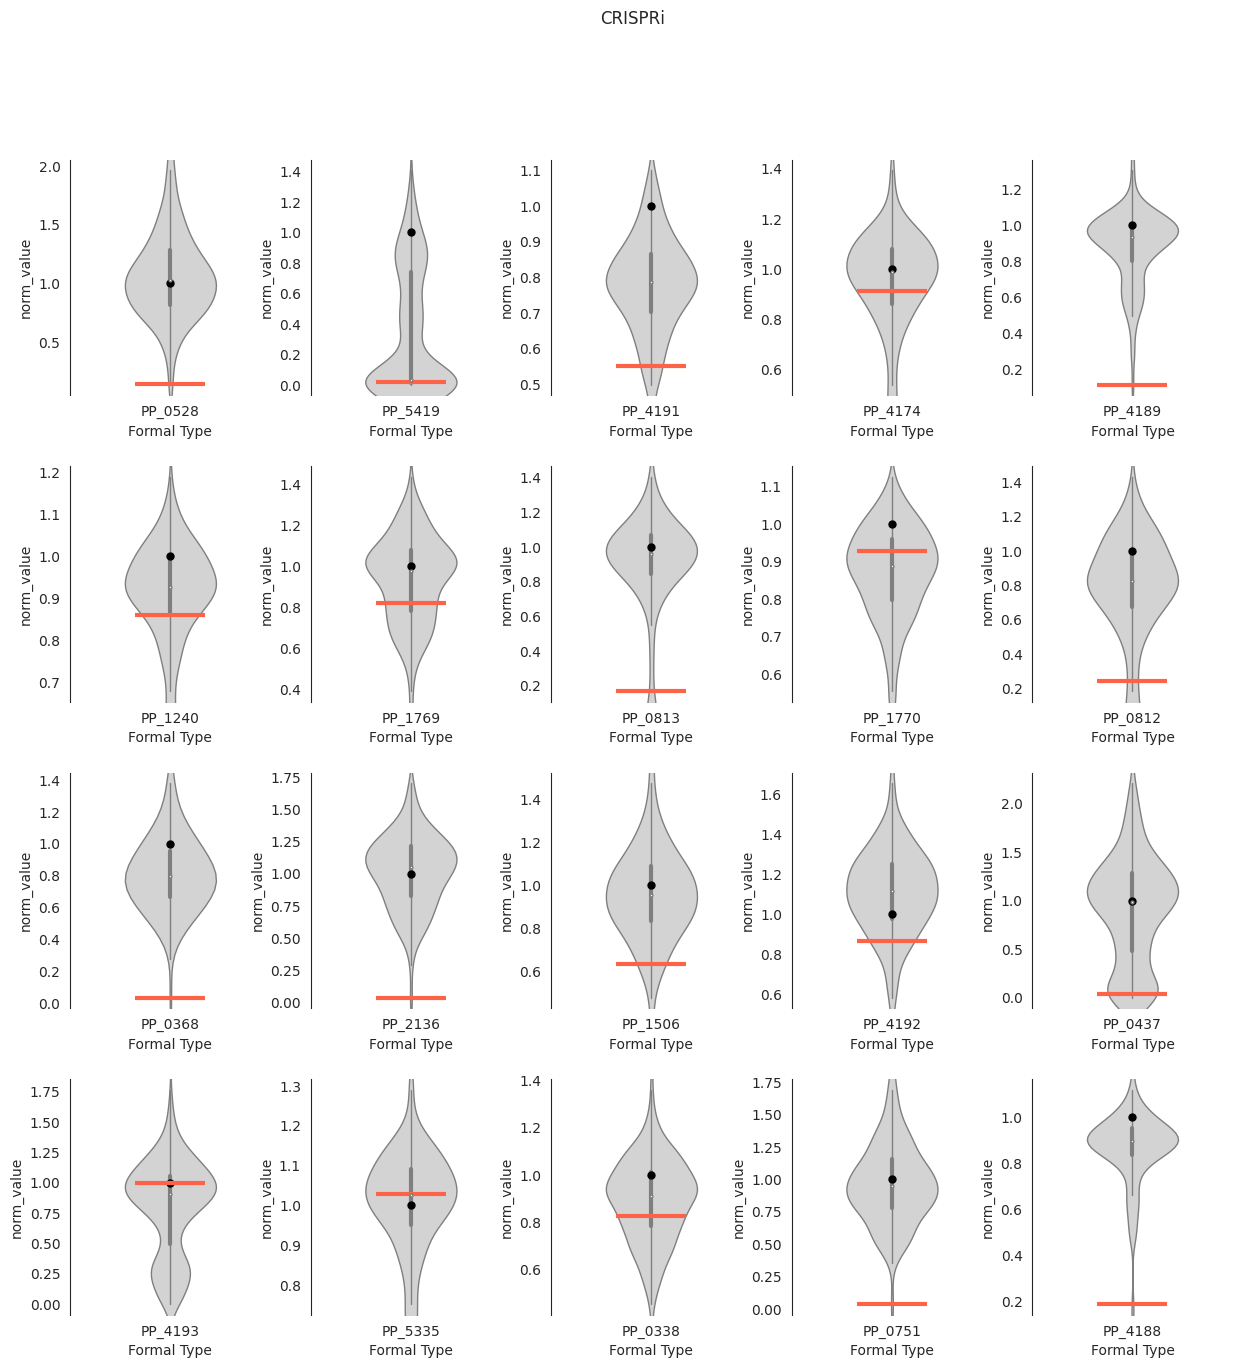

In [186]:
df_crispr = df_targets_norm.loc[df_targets_norm['Isoprenol mean'].dropna().index,:]
df_crispr.sort_values("Isoprenol mean", ascending = False, inplace = True)  

targets_all = list(df_crispr['Target'].values)
targets_filter = []
for tt in targets_all:
    if (sum(df_targets_norm['Target'] == tt) == 1) and (tt in df_norm['Formal Type'].unique()):
        targets_filter.append(tt)
targetsP = targets_filter[:20]

fig = plot_crispr_library(df_norm, df_targets_norm, targetsP, save=False, violin_field='norm_value')

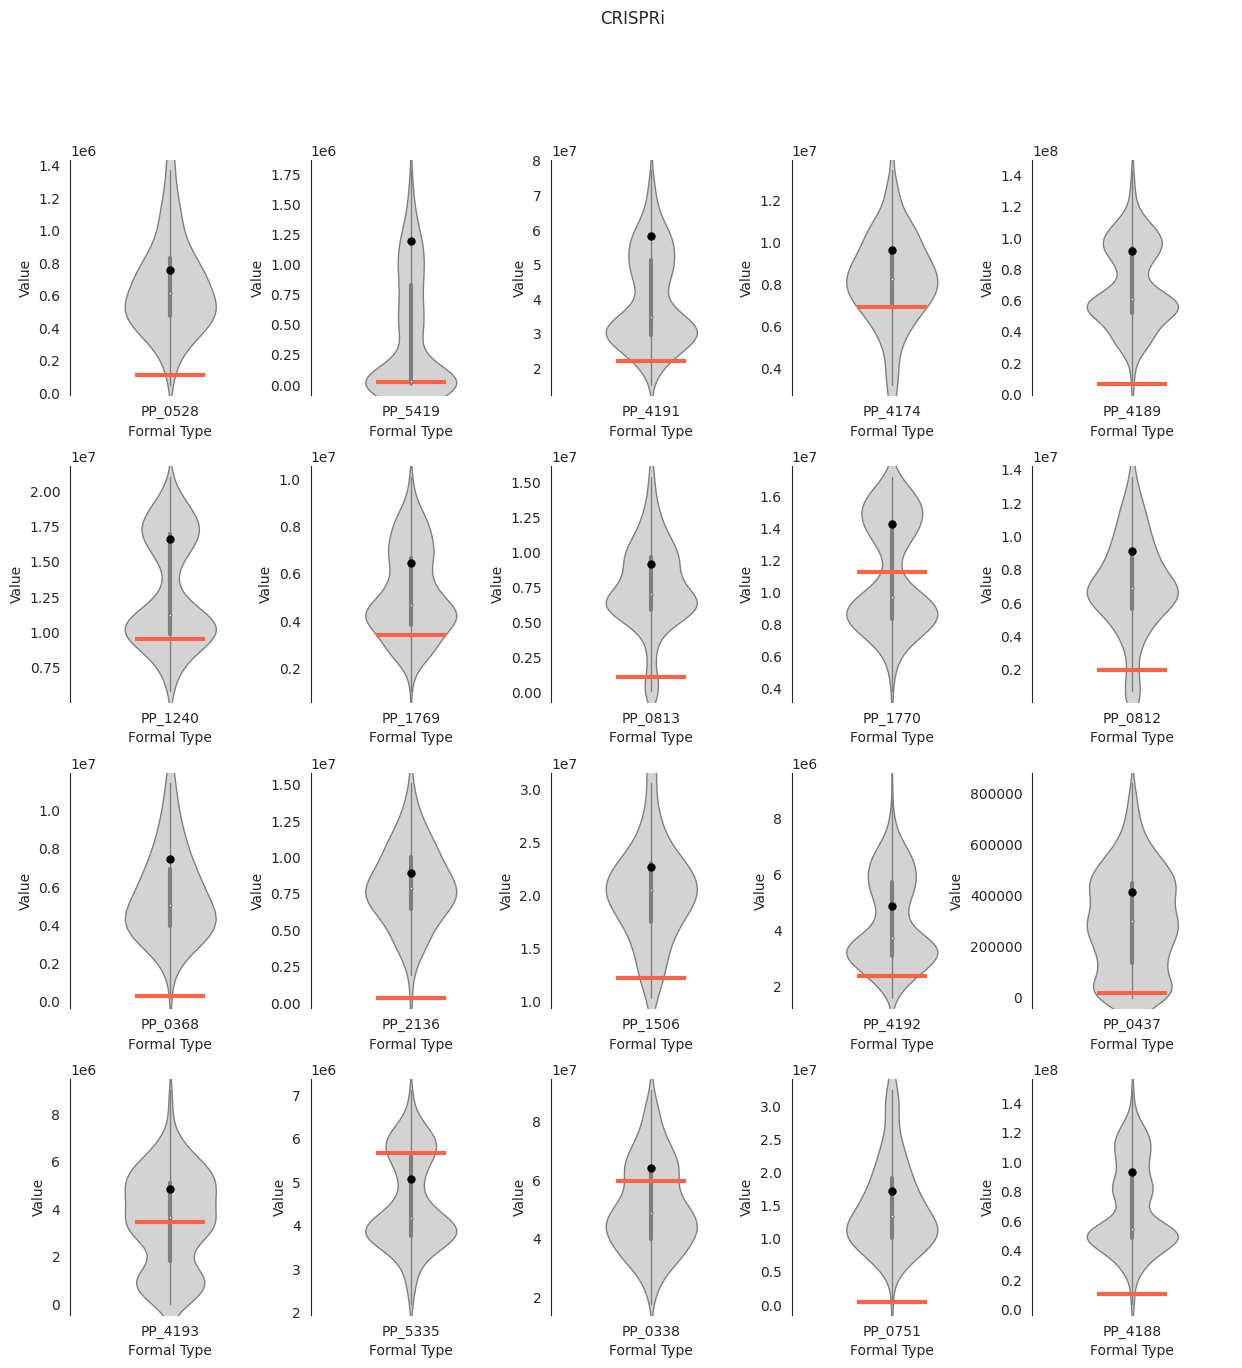

In [191]:
fig = plot_crispr_library(df_norm, df_targets, targetsP, save=False, violin_field='Value')

## Make Recommendations - Selecting Target Genes
Criteria for downselection:

Transcription value for the CRISPRi targeted gene:
Within the bottom 25th percentile of the library
More than 25% lower than the mean of the library

Define functions:

In [192]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [193]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [194]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

### Calculate ratios and filter out non-performing CRISPRi targets

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [200]:
df_targets_norm = find_fold_changes(df_targets_norm)
df_targets_norm.head()
df_targets = find_fold_changes(df_targets)

Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']
Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


In [256]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
df_filtering = df_targets_norm.loc[strains][cols]
df_filtering

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2192,PP_5064,15.849800,173.205081,0.979425,0.831695,1.174694,0.750364
IY1671,PP_4679,100.588117,109.824115,0.442137,0.681011,0.866659,0.553459
IY2025,PP_4119,27.581113,86.677767,0.176541,0.183362,0.212926,0.155034
IY2195,PP_1610,63.463733,62.467704,0.644333,0.794981,0.88753,0.714991
IY1597,PP_1607,275.054650,34.172646,None,None,None,None
...,...,...,...,...,...,...,...
IY1586,PP_4549,302.681833,1.258797,0.051375,0.073656,0.08812,0.062872
IY2047,PP_1317,228.187567,0.790181,0.016678,0.013555,0.016637,0.012274
IY1589,PP_2136,351.199900,0.74632,0.036127,0.03451,0.040185,0.031508


Drop lines that didn't perform. 

In [261]:
mean_thresh = 0.9
q1_thresh = 1
cntrl_thresh = 0.9
df_selection = df_filtering.loc[(
        (df_filtering['Target:Control']<cntrl_thresh) &
        (df_filtering['Target:Library_mean']<mean_thresh)
)
     & (df_filtering['Isoprenol mean']>100)
,:]
print(df_selection.shape)
df_selection.sort_values('Isoprenol mean', ascending = False).head()

(69, 7)


Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY1688,PP_0528,590.549567,2.279287,0.141462,0.128765,0.155832,0.118258
IY2020,PP_5419,587.181567,5.359461,0.016461,0.051165,1.046907,0.027034
IY2212,PP_4191,537.658933,2.56194,0.550993,0.71002,0.776548,0.662584
IY2037,PP_4189,437.093067,9.15967,0.113663,0.127683,0.136394,0.115065
IY2193,PP_1769,413.322400,14.603365,0.821499,0.874983,0.98883,0.794788


#### Plot results of filtering

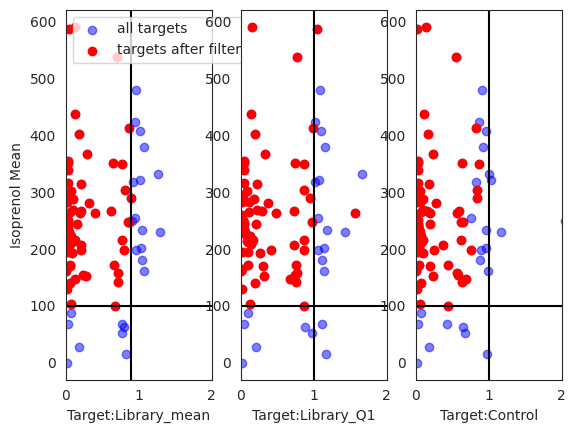

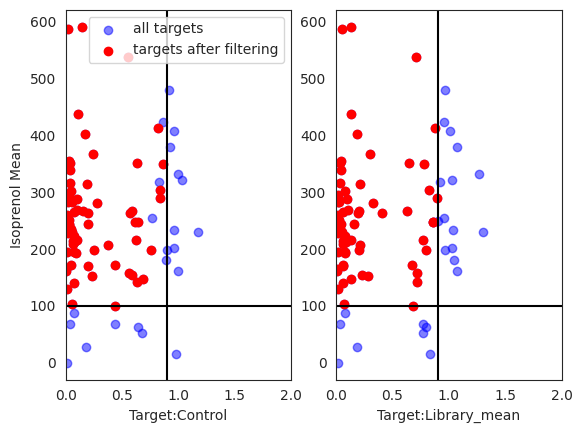

In [262]:
f = plot_filter_results(df_filtering, df_selection, 
                        [100, 100, 100], [mean_thresh, q1_thresh, 1],
                        ['Target:Library_mean', 'Target:Library_Q1', 'Target:Control'])
f = plot_filter_results(df_filtering, df_selection, 
                        [100, 100, 100], [cntrl_thresh, mean_thresh],
                        [ 'Target:Control', 'Target:Library_mean'])
  
# f.savefig(f"{user_params['output_dir']}/target_filter_results.png",
#           transparent = True,
#           bbox_inches = 'tight',
#           dpi = 300,
#          )



In [263]:
targets_selected = df_selection['Target'].unique()
# targets_not_selected
targets_selected
targets_not_selected = np.array([ii for ii in df_filtering['Target'].unique() if ii not in targets_selected])
print(f'len(targets_selected) = {len(targets_selected)} len(targets_not_selected) = {len(targets_not_selected)} total len = {len(df_filtering["Target"].unique())}')

len(targets_selected) = 69 len(targets_not_selected) = 53 total len = 122


Now that we have a list of the selected and not selected targets, look at the abundance in the NT strain

<AxesSubplot: xlabel='filter_in', ylabel='Value'>

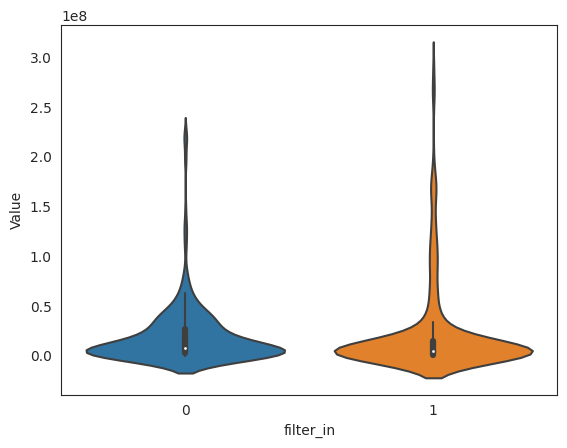

In [264]:
len(df_control['Target'].unique())
df_control['filter_in'] = 0
add_filter = lambda x: 1 if x in targets_selected else 0
df_control['filter_in'] = df_control['Formal Type'].apply(add_filter)
sns.violinplot(df_control[df_control['Protocol']=='Global Proteomics'], y = 'Value', x = 'filter_in', alpha = 0.3)
# plt.gca().set_yscale('log')


In [265]:
gene_targets= df_selection["Target"].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)
print(f'Max isoprenol in df selection {max(df_selection["Isoprenol mean"])}')


69 gene targets:
['PP_4679', 'PP_0813', 'PP_4187', 'PP_4192', 'PP_1607', 'PP_4678', 'PP_1755', 'PP_2471', 'PP_4185', 'PP_4651', 'PP_1769', 'PP_4186', 'PP_2137', 'PP_1444', 'PP_4121', 'PP_1319', 'PP_0658', 'PP_0437', 'PP_0168', 'PP_4189', 'PP_4116', 'PP_4550', 'PP_0597', 'PP_4862', 'PP_4667', 'PP_5417', 'PP_1506', 'PP_4188', 'PP_4011', 'PP_2213', 'PP_3071', 'PP_2339', 'PP_1620', 'PP_5419', 'PP_0812', 'PP_3122', 'PP_0774', 'PP_4266', 'PP_0897', 'PP_0368', 'PP_5186', 'PP_4636', 'PP_3578', 'PP_4123', 'PP_0944', 'PP_3123', 'PP_2095', 'PP_3755', 'PP_5203', 'PP_1457', 'PP_4487', 'PP_0654', 'PP_1318', 'PP_4191', 'PP_5288', 'PP_0528', 'PP_4122', 'PP_2925', 'PP_0999', 'PP_0751', 'PP_3365', 'PP_3754', 'PP_2112', 'PP_0226', 'PP_4120', 'PP_0582', 'PP_4549', 'PP_1317', 'PP_2136']
Max isoprenol in df selection 590.5495666666667


In [266]:
user_params['n_instances_double'] = 25
user_params['n_instances_triple'] = 25
user_params['n_replicates'] = 3 
df_targets2 = df_selection[["Target","Isoprenol mean"]]
df_targets2.columns.name=''
df_targets2

,Target,Isoprenol mean
Strain,,
IY1671,PP_4679,100.588117
IY2188,PP_0813,401.706750
IY2057,PP_4187,215.706100
IY2211,PP_4192,349.035467
IY1452,PP_1607,289.814111
...,...,...
IY2026,PP_4120,242.994757
IY1663,PP_0582,248.213333
IY1586,PP_4549,302.681833


In [267]:
control_production = df_targets_norm.loc["NT",'Isoprenol mean']
df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production
df_targets2

/tmp/ipykernel_1409066/4108564400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production


,Target,Isoprenol mean,Ratio
Strain,,,
IY1671,PP_4679,100.588117,0.395007
IY2188,PP_0813,401.706750,1.577494
IY2057,PP_4187,215.706100,0.847073
IY2211,PP_4192,349.035467,1.370655
IY1452,PP_1607,289.814111,1.138094
...,...,...,...
IY2026,PP_4120,242.994757,0.954235
IY1663,PP_0582,248.213333,0.974728
IY1586,PP_4549,302.681833,1.188625


As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [268]:
df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)
df_targets2 = df_targets2.astype({'Weight': 'int'})
df_targets2

/tmp/ipykernel_1409066/2229913683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)


,Target,Isoprenol mean,Ratio,Weight
Strain,,,,
IY1671,PP_4679,100.588117,0.395007,9
IY2188,PP_0813,401.706750,1.577494,21
IY2057,PP_4187,215.706100,0.847073,13
IY2211,PP_4192,349.035467,1.370655,19
IY1452,PP_1607,289.814111,1.138094,16
...,...,...,...,...
IY2026,PP_4120,242.994757,0.954235,15
IY1663,PP_0582,248.213333,0.974728,15
IY1586,PP_4549,302.681833,1.188625,17


And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [269]:
df_targets2 = df_targets2[['Target', 'Isoprenol mean','Weight']]
n_targets = len(df_targets2['Target'])
df_targets2.head()

,Target,Isoprenol mean,Weight
Strain,,,
IY1671,PP_4679,100.588117,9
IY2188,PP_0813,401.706750,21
IY2057,PP_4187,215.706100,13
IY2211,PP_4192,349.035467,19
IY1452,PP_1607,289.814111,16


### Check correlation between target selection and titer

Select a bunch of single targets (so that repeats don't affect picks) and plot their occurence vs. titer.

Text(0.5, 1.0, 'With weighting')

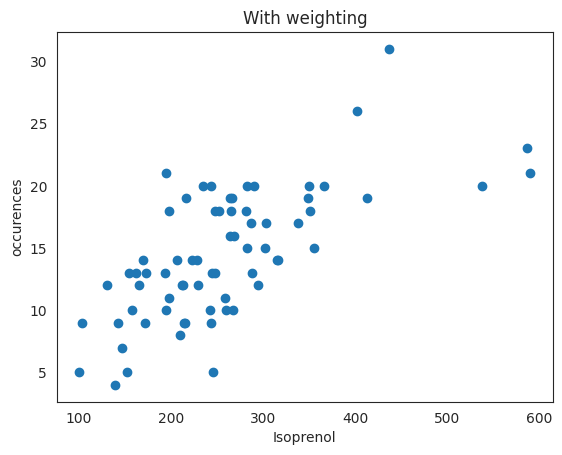

In [270]:
#Get random individual picks
targets_test = []
targets_test_nowt = []
for ii in range(1000):
    target_test = choose_targets(df_targets2, size = 1, weighting=True, n_instances=1)
    target_test_nowt = choose_targets(df_targets2, size = 1, weighting=False, n_instances=1)
    targets_test.append(target_test[0][0])
#Get unique
df_targets_test = df_targets2.copy()
df_targets_test['occurences'] = 0
count_occurences = lambda x: targets_test.count(x)
df_targets_test['occurences'] = df_targets_test['Target'].apply(count_occurences)
df_targets_test.head()
fig, ax = plt.subplots(1,1)
ax.scatter(df_targets_test['Isoprenol mean'], df_targets_test['occurences'])
plt.xlabel('Isoprenol')
plt.ylabel('occurences')
plt.title('With weighting')



In [271]:
list(np.unique(targets_test))

['PP_0168',
 'PP_0226',
 'PP_0368',
 'PP_0437',
 'PP_0528',
 'PP_0582',
 'PP_0597',
 'PP_0654',
 'PP_0658',
 'PP_0751',
 'PP_0774',
 'PP_0812',
 'PP_0813',
 'PP_0897',
 'PP_0944',
 'PP_0999',
 'PP_1317',
 'PP_1318',
 'PP_1319',
 'PP_1444',
 'PP_1457',
 'PP_1506',
 'PP_1607',
 'PP_1620',
 'PP_1755',
 'PP_1769',
 'PP_2095',
 'PP_2112',
 'PP_2136',
 'PP_2137',
 'PP_2213',
 'PP_2339',
 'PP_2471',
 'PP_2925',
 'PP_3071',
 'PP_3122',
 'PP_3123',
 'PP_3365',
 'PP_3578',
 'PP_3754',
 'PP_3755',
 'PP_4011',
 'PP_4116',
 'PP_4120',
 'PP_4121',
 'PP_4122',
 'PP_4123',
 'PP_4185',
 'PP_4186',
 'PP_4187',
 'PP_4188',
 'PP_4189',
 'PP_4191',
 'PP_4192',
 'PP_4266',
 'PP_4487',
 'PP_4549',
 'PP_4550',
 'PP_4636',
 'PP_4651',
 'PP_4667',
 'PP_4678',
 'PP_4679',
 'PP_4862',
 'PP_5186',
 'PP_5203',
 'PP_5288',
 'PP_5417',
 'PP_5419']

### Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

28
('PP_1318', 'PP_4487')
('PP_0654', 'PP_4651')
('PP_1444', 'PP_4191')
('PP_4192', 'PP_4678')
('PP_0368', 'PP_0437')
('PP_0897', 'PP_1620')
('PP_2137', 'PP_4651')
('PP_2925', 'PP_4487')
('PP_4192', 'PP_5419')
('PP_1319', 'PP_4550')
('PP_0944', 'PP_1755')
('PP_2471', 'PP_4549')
('PP_0582', 'PP_1607')
('PP_1607', 'PP_5288')
('PP_1607', 'PP_2137')
('PP_0368', 'PP_0751')
('PP_2136', 'PP_5288')
('PP_0944', 'PP_2137')
('PP_0658', 'PP_4550')
('PP_0658', 'PP_4487')
('PP_4549', 'PP_4636')
('PP_0654', 'PP_2112')
('PP_0751', 'PP_4667')
('PP_0812', 'PP_3122')
('PP_4192', 'PP_4636')


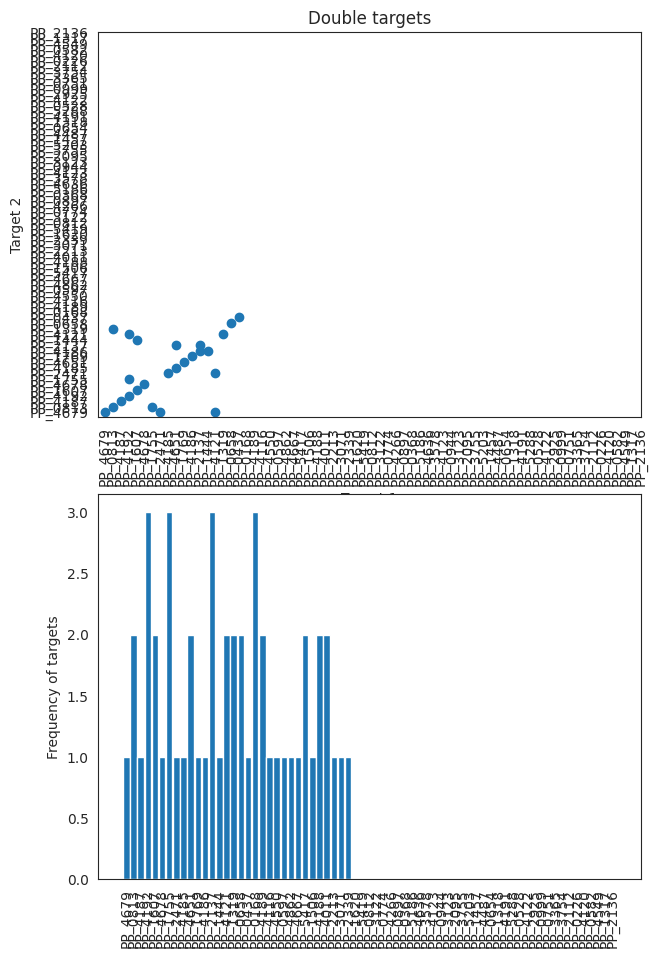

In [272]:
targets_double = choose_targets(
    df_targets2, 
    size=2, 
    n_instances= user_params['n_instances_double'],
    verbose=1
)

for target in targets_double:
    print(target)
    
#Save to file: 
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        f.write(str(target))
        
plot_double_targets(targets_double, df_targets2)


### Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

[('PP_0999', 'PP_1317', 'PP_5417'), ('PP_0368', 'PP_0528', 'PP_0774'), ('PP_1457', 'PP_3578', 'PP_5288'), ('PP_1607', 'PP_4192', 'PP_4487'), ('PP_1457', 'PP_2339', 'PP_2471'), ('PP_0582', 'PP_3754', 'PP_5288'), ('PP_0813', 'PP_4187', 'PP_5419'), ('PP_0582', 'PP_0813', 'PP_4121'), ('PP_4120', 'PP_4188', 'PP_4487'), ('PP_0528', 'PP_0751', 'PP_2137'), ('PP_1319', 'PP_3365', 'PP_4189'), ('PP_0528', 'PP_4636', 'PP_5186'), ('PP_0654', 'PP_0944', 'PP_0999'), ('PP_2137', 'PP_2471', 'PP_3754'), ('PP_0944', 'PP_0999', 'PP_1457'), ('PP_0813', 'PP_4191', 'PP_4266'), ('PP_1755', 'PP_2136', 'PP_5203'), ('PP_0168', 'PP_1506', 'PP_3071'), ('PP_4191', 'PP_4862', 'PP_5203'), ('PP_0751', 'PP_2213', 'PP_4651'), ('PP_0597', 'PP_1444', 'PP_5288'), ('PP_3365', 'PP_4191', 'PP_4651'), ('PP_0226', 'PP_0368', 'PP_1769'), ('PP_0774', 'PP_0812', 'PP_5288'), ('PP_2136', 'PP_4189', 'PP_5288')]


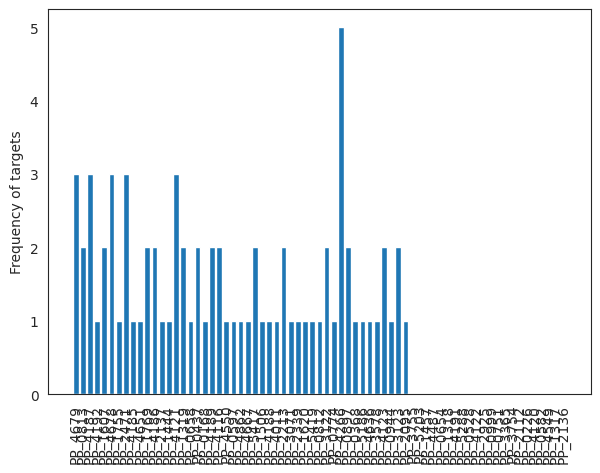

In [273]:
targets_triple = choose_targets(
    df_targets2, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

print(targets_triple)

plot_triple_targets(targets_triple, df_targets2)

with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        f.write(str(target))